In [19]:
# Manipulation de données 
import pandas as pd 
import numpy as np



# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image



# Preprocessing des reviews 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

    # Pour filtrer la langue des avis
from langdetect import detect, DetectorFactory 
from langdetect.lang_detect_exception import LangDetectException



# Modelisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA




# Pour enregistrer et charger les modèles
import joblib

# CHARGEMENT DES DONNEES

In [2]:
# Initialisation d'un dataframe vide
df = pd.read_csv('Data/avis_ugc_clean.csv')

In [3]:
df.head()

,rating,date,review,likes,user_name,user_nb_reviews,user_nb_photos,cinéma,language
0,1,2024-11-10 07:41:00+00:00,Il n’a pas admissible qu’une grosse chaîne de ...,0,anne degroux,2,0,UGC Ciné Cité Les Halles,fr
1,4,2024-11-09 10:32:00+00:00,"Pratique, plein de salles et bonne programmati...",0,Géraldine Sauvenay,3,0,UGC Ciné Cité Les Halles,fr
2,3,2024-11-09 08:45:00+00:00,"Nettoyez vos écrans, ça commence à se voir !",0,M G,2,0,UGC Ciné Cité Les Halles,fr
3,1,2024-11-08 20:13:00+00:00,The theater still has a bed bug problem. Sat d...,0,Cordelia Ryan,2,1,UGC Ciné Cité Les Halles,fr
4,1,2024-11-08 15:32:00+00:00,VOLUME beaucoup trop fort mon dieu!! On était ...,0,Spei,83,0,UGC Ciné Cité Les Halles,fr


# PREPROCESSING

Avant de passer nos données dans les modèles, nous devons les mettre en forme. Tout d’abord, j’ai constaté que la colonne `language` contient souvent des informations incorrectes sur la langue. Pour remédier à cela, nous allons utiliser la librairie `langdetect`, qui s’appuie sur la détection de langue de Google pour identifier la langue correcte.

In [4]:
"""df_clean = df.copy()"""

# Importation du fichier déjà nettoyé car le code est long à tourner
df_clean = pd.read_csv('Data/avis_ugc_fr.csv')

In [5]:
"""DetectorFactory.seed = 24

# Fonction pour détecter la langue d'un texte donné
def detect_language(text: str) -> str | None:
    try:
        # Tente de détecter la langue du texte
        return detect(text)
    except LangDetectException:
        # En cas d'erreur (par exemple, si le texte est vide ou ambigu), retourne None
        return None

# Applique la fonction de détection de langue à chaque avis dans la colonne 'review'
df_clean['language_detected'] = df_clean['review'].map(detect_language)

# Filtre les données pour ne conserver que les avis détectés en français ('fr')
df_clean = df[df['language_detected'] == 'fr']

# Exporte le DataFrame filtré dans un fichier CSV
df_clean.to_csv('Data/avis_ugc_fr.csv', index=False)"""

"DetectorFactory.seed = 24\n\n# Fonction pour détecter la langue d'un texte donné\ndef detect_language(text: str) -> str | None:\n    try:\n        # Tente de détecter la langue du texte\n        return detect(text)\n    except LangDetectException:\n        # En cas d'erreur (par exemple, si le texte est vide ou ambigu), retourne None\n        return None\n\n# Applique la fonction de détection de langue à chaque avis dans la colonne 'review'\ndf_clean['language_detected'] = df_clean['review'].map(detect_language)\n\n# Filtre les données pour ne conserver que les avis détectés en français ('fr')\ndf_clean = df[df['language_detected'] == 'fr']\n\n# Exporte le DataFrame filtré dans un fichier CSV\ndf_clean.to_csv('Data/avis_ugc_fr.csv', index=False)"

In [6]:
print(f" Nombre d'avis non francais supprimés : {df.shape[0] - df_clean.shape[0]}")

 Nombre d'avis non francais supprimés : 12206


In [7]:
# Importation des stop words français de la librairie NLTK
stop_words = set(stopwords.words('french'))

# Ajout de stop words détectés dans les avis 
custom_stop_words = {",", ".", "a", "c'est", "!", "film", "cinéma", 
                     "si", "plus", "ugc", "ca", "là", "où", "deux", 
                     "ça", "h", "qu", "il", "''", '``', "-", "(", ")",
                     "..", "€", "?", "....", "//", ":", "/", ";", '’'
                    }
stop_words.update(custom_stop_words)

# Initialisation d'un lemmatiseur pour réduire les mots à leur forme de base
lemmatizer = WordNetLemmatizer()

def preprocess_reviews(reviews: pd.Series) -> pd.Series:
    """
    Cette fonction prend une série pandas contenant des avis textuels et applique un prétraitement
    pour chaque avis. Elle effectue les étapes suivantes :
    
    1. Convertit chaque avis en minuscules pour uniformiser le texte.
    2. Supprime les chiffres et remplace les apostrophes par des espaces pour éviter les séparations incorrectes.
    3. Tokenise chaque avis, c'est-à-dire qu'elle divise le texte en mots individuels.
    4. Supprime les stop words (mots courants sans importance) à partir d'une liste de stop words standard en français,
       enrichie de mots spécifiques au contexte.
    5. Applique la lemmatisation, qui réduit les mots à leur forme de base (par exemple, "films" devient "film").
    
    Paramètres :
    reviews (pd.Series) : Série pandas contenant les avis textuels.
    
    Retourne :
    pd.Series : Série pandas contenant des listes de mots prétraités pour chaque avis.
    """    
    
    # Convertir en minuscules et supprimer les chiffres et les apostrophes
    reviews = reviews.str.lower().str.replace(r'\d+', '', regex=True).str.replace("'", ' ')

    # Appliquer tokenisation, suppression des stop words, et lemmatisation
    reviews = reviews.apply(lambda review: [lemmatizer.lemmatize(word) 
                                            for word in word_tokenize(review) 
                                            if word not in stop_words
                                           ])


    return reviews

In [8]:
reviews = preprocess_reviews(df_clean['review'])

In [9]:
def my_word_cloud(reviews: pd.Series, title: str = None, subplot: tuple[int] = None, background_image_path: str = None) -> None:
    """
    Génère et affiche un nuage de mots basé sur le contenu textuel d'une série pandas contenant des avis.
    La fonction peut également afficher le nuage de mots sur une image de fond spécifiée.
    
    Paramètres :
    - reviews (pd.Series) : Série pandas contenant les avis textuels. Tous les avis sont concaténés pour créer le nuage de mots.
    - title (str, optionnel) : Titre à afficher au-dessus du nuage de mots. Si None, aucun titre n'est affiché.
    - subplot (tuple[int], optionnel) : Spécifie l'emplacement du nuage de mots dans une grille de sous-plots sous la forme (nrows, ncols, index).
      Utilisé lorsque le nuage de mots doit être affiché dans une figure avec plusieurs sous-graphiques.
    - background_image_path (str, optionnel) : Chemin d'accès à une image de fond pour le nuage de mots.
      Si fourni, le nuage de mots prendra la forme de cette image. Si None, le fond sera blanc par défaut.
    
    Retourne :
    - None : La fonction affiche directement le nuage de mots en utilisant `matplotlib.pyplot` et ne retourne rien.
    """
    
    # Concatène tous les avis en une seule chaîne de texte
    text = ' '.join(reviews.astype(str))
    
    # Charge l'image de fond si spécifiée, sinon crée un nuage de mots avec un fond blanc
    if background_image_path is not None:
        background_image = np.array(Image.open(background_image_path))
        wordcloud = WordCloud(width=800, height=400, background_color='white', mask=background_image, contour_width=1, contour_color='black').generate(text)
    else:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    

    plt.figure(figsize=(10, 5))
    
    # Positionne le nuage de mots dans un sous-plot si `subplot` est spécifié
    if subplot is not None :
        plt.subplot(subplot[0], subplot[1], subplot[2])
    
    # Affiche le nuage de mots et enlève les axes
    plt.imshow(wordcloud)
    plt.axis('off')
    
    # Ajoute un titre si spécifié
    if title is not None:
        plt.title(title)
    
    plt.show()

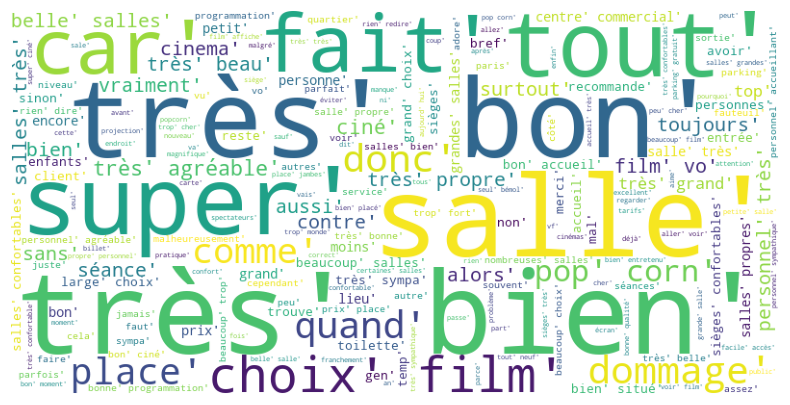

In [10]:
my_word_cloud(reviews)

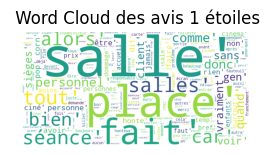

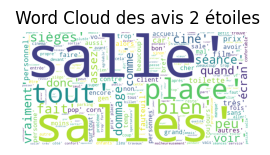

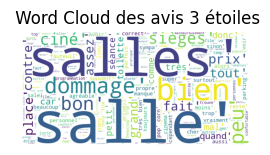

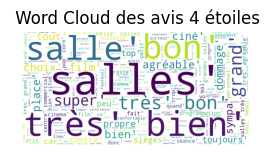

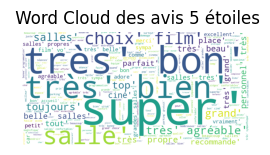

In [11]:
# Boucle pour afficher un word cloud pour chaque note
for i in np.sort(df_clean['rating'].unique()):
    reviews_per_note =  preprocess_reviews(df_clean[df_clean['rating'] == i]['review'])
    
    title = f' Word Cloud des avis {i} étoiles'
    my_word_cloud(reviews_per_note, title, subplot=(3,2,i))

* Le mot "salle(s)" apparaît aussi bien dans les avis positifs que négatifs, ce qui suggère qu'il n'est pas un indicateur fiable de sentiment. Il serait donc pertinent de le retirer, au moins pour la création du nuage de mots, afin d'obtenir une visualisation plus représentative des termes associés aux avis positifs ou négatifs.

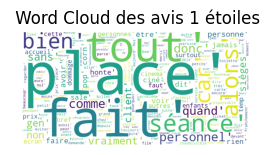

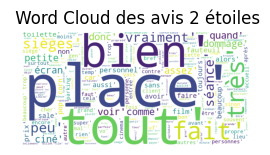

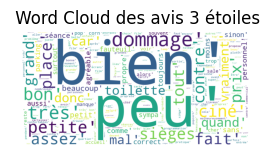

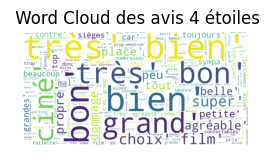

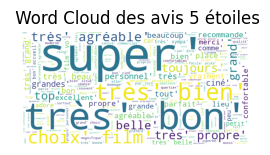

In [12]:
# Boucle pour afficher un word cloud pour chaque note
for i in np.sort(df_clean['rating'].unique()):
    reviews_per_note =  preprocess_reviews(df_clean[df_clean['rating'] == i]['review'])
    
    reviews_per_note = reviews_per_note.apply(lambda words: [word for word in words if word not in ['salle', 'salles']])
    
    title = f' Word Cloud des avis {i} étoiles'
    my_word_cloud(reviews_per_note, title, subplot=(3,2,i))

1. **Word Cloud des avis 1 étoile :**

    * Les mots les plus fréquents incluent "place", "séance", et "bien". Cela pourrait suggérer des commentaires sur l'emplacement, l'organisation des séances, ou même des aspects de confort. Cependant, dans un contexte de note basse, ces termes sont probablement utilisés de manière négative (ex. : mauvaise organisation des séances, inconfort des places).
    * Les termes "dommage", "problème", et "mal" apparaissent également, ce qui renforce l'idée de critiques.

2. **Word Cloud des avis 2 étoiles :**

    * On retrouve des mots similaires comme "place" et "tout". "Dommage" est également présent, ce qui indique des critiques mitigées.
    * Le mot "bien" reste fréquent, mais dans ce contexte, il pourrait être utilisé pour souligner des aspects corrects dans un avis globalement négatif.

3. **Word Cloud des avis 3 étoiles :**

    * Les termes "bien" et "peu" sont dominants, suggérant des avis modérés où des aspects positifs sont soulignés, mais avec des réserves (ex. : "peu d'espace", "bien mais pourrait être mieux").
    * D’autres mots comme "dommage", "prix", et "petite" indiquent probablement des points d'amélioration signalés par les utilisateurs.

4. **Word Cloud des avis 4 étoiles :**

    * Le mot "bien" devient encore plus dominant, accompagné de "très", "bon", et "propre". Cela suggère des avis majoritairement positifs, où la qualité et le confort sont reconnus.
    * Des termes comme "agréable" et "choix" apparaissent, ce qui peut indiquer une satisfaction avec les options disponibles et l’atmosphère générale.

5. **Word Cloud des avis 5 étoiles :**

    * Les mots les plus fréquents sont "très", "super", "bien", et "agréable", soulignant une satisfaction élevée.
    * On voit aussi "parfait", "personnel", et "choix", ce qui indique une expérience globalement positive avec de nombreux aspects appréciés, y compris le service.

# MODELISATION : Identifier les différentes thématiques des avis

## Utilisation de méthode classique (TF-IDF)

In [13]:
# transformation des avis en une liste de texte
reviews = [' '.join(review) for review in reviews]

# On applique la transformation TF-IDF aux avis pour obtenir une matrice sparse des scores TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(reviews)

### HDBSCAN

> DBSCAN identifie des clusters en regroupant les points qui se trouvent dans des zones de densité uniforme, ce qui limite sa capacité pour des données à densité variable.
>
> HDBSCAN est une version améliorée qui détecte les clusters de densité variable de manière hiérarchique, permettant une identification plus flexible et automatique des groupes dans des ensembles de données complexes. HDBSCAN n’a pas besoin de définir `eps` et se base principalement sur deux paramètres : `min_cluster_size` (taille minimale pour un cluster) et `min_samples` (contrôle de la sensibilité au bruit).

In [20]:
pca_hdbscan = PCA(n_components=100) 
reduced_vectors = pca_hdbscan.fit_transform(X)

sum(pca_hdbscan.explained_variance_ratio_)

0.4654675271724484

In [21]:
"""hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3)
hdbscan_model.fit(reduced_vectors)"""

hdbscan_model = joblib.load('Entrainement_modeles_tfidf/hdbscan_tfidf.joblib')

# Résultats des clusters
labels_hdbscan = hdbscan_model.labels_

calinski_score = calinski_harabasz_score(reduced_vectors, labels_hdbscan)
print("Score de Calinski-Harabasz :", calinski_score) 

"""joblib.dump(hdbscan_model, 'Entrainement_modeles_tfidf/hdbscan_tfidf.joblib')"""

Score de Calinski-Harabasz : 216.06895844984834


"joblib.dump(hdbscan_model, 'Entrainement_modeles_tfidf/hdbscan_tfidf.joblib')"

In [22]:
df_clean['HDBSCAN_labels'] = labels_hdbscan

df_clean.groupby('HDBSCAN_labels').agg(rating_mean=('rating', 'mean'),
                                rating_Count=('rating', 'count')
                               ).sort_values(by='rating_mean', ascending=False)

,rating_mean,rating_Count
HDBSCAN_labels,,
5,4.836364,110
2,4.813793,145
4,4.777027,148
7,4.757282,103
16,4.745098,204
10,4.717742,372
9,4.664000,125
8,4.652893,121
13,4.574746,689


### K-mean

In [23]:
# Calcul du score de silhouette pour déterminer le nombre optimal de clusters
"""silhouette_scores = []
range_n_clusters = range(5, 20)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=24)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print('nombre clusters :', n_clusters, silhouette_avg)

# Tracer le score de silhouette pour chaque nombre de clusters
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Method")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.show()"""

# Choisir le nombre optimal de clusters
"""optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]"""

optimal_clusters = joblib.load('Entrainement_modeles_tfidf/optimal_clusters_kmean_tfidf.joblib')

"""joblib.dump(optimal_clusters, 'Entrainement_modeles_tfidf/optimal_clusters_kmean_tfidf.joblib')"""

print(f"Nombre de clusters optimal basé sur le score de silhouette: {optimal_clusters}")

Nombre de clusters optimal basé sur le score de silhouette: 19


In [24]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=24)

df_clean['Kmean_labels'] = kmeans.fit_predict(X)

df_clean.groupby('Kmean_labels').agg(rating_mean=('rating', 'mean'),
                                rating_Count=('rating', 'count')
                               ).sort_values(by='rating_mean', ascending=False)

,rating_mean,rating_Count
Kmean_labels,,
7,4.682262,1945
13,4.533499,1612
14,4.517990,1612
15,4.489268,1584
4,4.459880,2505
18,4.442989,2596
8,4.397461,3072
17,4.276243,1991
11,4.237023,2042


### CHA

* Je n'ai pas pu implémenter cet algorithme en raison de problèmes de mémoire que je n'ai pas réussi à résoudr.CHA attend un vecteur dense ce qui consomme beaucoup trop de mémoire. Je partage néanmoins le code ci-dessous pour référence.

```python
# Clustering hiérarchique avec AgglomerativeClustering
ca_clustering = AgglomerativeClustering(n_clusters=10)
labels_cah = ca_clustering.fit_predict(X.toarray())

# Calcul du score de silhouette pour évaluer la qualité des clusters
silhouette_avg = silhouette_score(X.toarray(), labels_cah)
print(f"Score de silhouette pour le CAH : {silhouette_avg}")

# Visualisation du dendrogramme pour voir la hiérarchie des clusters
linked = linkage(X.toarray(), 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=reviews, distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrogramme du clustering hiérarchique")
plt.xlabel("Index des reviews")
plt.ylabel("Distance")
plt.show()
```

### LDA

In [25]:
"""lda = LatentDirichletAllocation(n_components=10, random_state=24)
lda.fit(X)

topic_values = lda.transform(X)"""

lda, topic_values = joblib.load('Entrainement_modeles_tfidf/lda_tfidf.joblib')

"""joblib.dump((lda, topic_values), 'Entrainement_modeles_tfidf/lda_tfidf.joblib')"""

"joblib.dump((lda, topic_values), 'Entrainement_modeles_tfidf/lda_tfidf.joblib')"

In [26]:
df_clean['LDA_labels'] = np.argmax(topic_values, axis=1)

df_clean.groupby('LDA_labels').agg(rating_mean=('rating', 'mean'),
                                rating_Count=('rating', 'count')
                               ).sort_values(by='rating_mean', ascending=False)

,rating_mean,rating_Count
LDA_labels,,
17,4.507682,3059
12,4.501763,3119
8,4.493172,3808
18,4.385957,2350
11,4.336905,5040
0,4.285150,3542
13,4.148533,2794
2,4.061117,3796
14,4.024601,3130


### Conclusion

Nous obtenons de meilleurs résultats avec le modèle Latent Dirichlet Allocation (LDA), qui est bien adapté à notre problème de regroupement thématique des avis. En effet, LDA est conçu pour identifier des thèmes sous-jacents dans des documents textuels, ce qui permet de regrouper les avis en thématiques relativement homogènes. LDA a également permis de mettre en évidence des différences entre les groupes en termes de notes associées. Cependant, pour exploiter pleinement le potentiel de LDA, il reste essentiel d’optimiser ses hyperparamètres afin d’obtenir des clusters plus précis.

HDBSCAN, bien que potentiellement adapté pour identifier des clusters de forme et de densité variées, n’a pas encore donné de résultats satisfaisants probablement en raison de réglages d’hyperparamètres sous-optimaux. HDBSCAN peut être utile pour notre problème si nous parvenons à optimiser ces paramètres, car il pourrait détecter des groupes d'avis bien distincts, notamment des groupes d’avis extrêmes (très positifs ou très négatifs) sans forcer une structure sphérique comme K-Means. Il reste néanmoins limité dans un contexte de données textuelles de grande dimension.

K-Means a également été utilisé, mais cet algorithme n’est pas parfaitement adapté à notre problème. En effet, K-Means fonctionne mieux avec des clusters de forme sphérique et nécessite un calcul intensif des distances, ce qui devient coûteux en termes de mémoire et de temps d'exécution lorsque le volume de données textuelles et la dimensionnalité des vecteurs sont élevés (nous utilisons des vecteurs de dimension 1000). K-Means est moins performant pour capturer des relations complexes entre les thèmes des avis et se révèle inadapté aux données textuelles non linéaires.

Un autre défi majeur est lié à l’utilisation de TF-IDF, qui présente des limites pour représenter le texte. Bien qu’il permette de transformer les avis en vecteurs, TF-IDF ne capture pas les relations contextuelles entre les mots et se limite à la fréquence de chaque mot dans les documents. Par conséquent, des mots ayant des significations similaires mais des formes différentes (par exemple, "excellent" et "super") ne sont pas traités comme liés, ce qui réduit la cohérence des clusters. De plus, TF-IDF produit des vecteurs de grande dimension, entraînant une consommation importante de mémoire sans pour autant améliorer la qualité des clusters.

Pour surmonter ces limitations, nous allons explorer des méthodes plus avancées, notamment des techniques de Deep Learning telles que les embeddings de texte. Les embeddings permettent de réduire la dimensionnalité tout en capturant des relations sémantiques et contextuelles riches entre les mots. En utilisant des embeddings préentraînés ou des modèles de transformers, nous pourrons mieux représenter les avis sous forme de vecteurs de faible dimension mais significatifs, optimisant ainsi les ressources mémoire et accélérant les calculs. Cette approche devrait nous permettre d’obtenir des clusters plus cohérents et représentatifs des thèmes exprimés dans les avis.